<a href="https://colab.research.google.com/github/FriendlyUser/finance-notebooks/blob/master/Stock_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

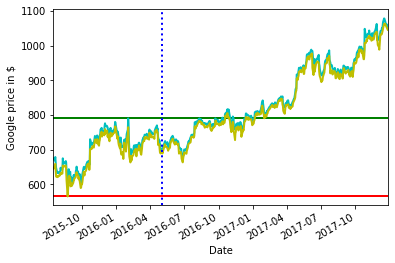

In [0]:
import pandas as pd
from pandas_datareader import data
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'
try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)
  goog_data=goog_data2.tail(620)
  lows=goog_data['Low']
  highs=goog_data['High']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1]
,linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1],
linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.show()

In this plot, the following applies:

1.  We draw the highs and lows of the GOOG price.
2.   The green line represents the resistance level, and the red line represents the support level.
3. To build these lines, we use the maximum value of the GOOG price and the
minimum value of the GOOG price stored daily.
4, After the 200th day (dotted vertical blue line), we will buy when we reach the support line, and sell when we reach the resistance line. In this example, we used 200 days so that we have sufficient data points to get an estimate of the trend.
5. It is observed that the GOOG price will reach the resistance line around August 2016. This means that we have a signal to enter a short position (sell).
6. Once traded, we will wait to get out of this short position when the GOOG price will reach the support line. With this historical data, it is easily noticeable that this condition will not happen.
7. This will result in carrying a short position in a rising market without having any signal to sell it, thereby resulting in a huge loss.

File data found...reading GOOG data


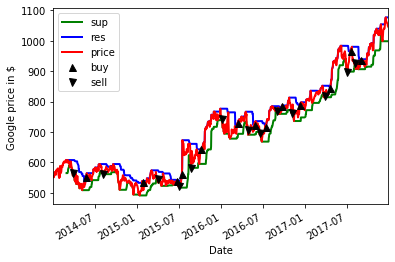

In [0]:
import pandas as pd
import numpy as np
from pandas_datareader import data
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'
try:
  goog_data = pd.read_pickle(SRC_DATA_FILENAME)
  print('File data found...reading GOOG data')
except FileNotFoundError:
  print('File not found...downloading the GOOG data')
  goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data.to_pickle(SRC_DATA_FILENAME)

goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']

def trading_support_resistance(data, bin_width=20):
  data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
  data['res_tolerance'] = pd.Series(np.zeros(len(data)))
  data['sup_count'] = pd.Series(np.zeros(len(data)))
  data['res_count'] = pd.Series(np.zeros(len(data)))
  data['sup'] = pd.Series(np.zeros(len(data)))
  data['res'] = pd.Series(np.zeros(len(data)))
  data['positions'] = pd.Series(np.zeros(len(data)))
  data['signal'] = pd.Series(np.zeros(len(data)))
  in_support=0
  in_resistance=0
  for x in range((bin_width - 1) + bin_width, len(data)):
    data_section = data[x - bin_width:x + 1]
    support_level=min(data_section['price'])
    resistance_level=max(data_section['price'])
    range_level=resistance_level-support_level
    data['res'][x]=resistance_level
    data['sup'][x]=support_level
    data['sup_tolerance'][x]=support_level + 0.2 * range_level
    data['res_tolerance'][x]=resistance_level - 0.2 * range_level
    if data['price'][x]>=data['res_tolerance'][x] and\
      data['price'][x] <= data['res'][x]:
      in_resistance+=1
      data['res_count'][x]=in_resistance
    elif data['price'][x] <= data['sup_tolerance'][x] and \
      data['price'][x] >= data['sup'][x]:
      in_support += 1
      data['sup_count'][x] = in_support
    else:
      in_support=0
      in_resistance=0
    if in_resistance>2:
      data['signal'][x]=1
    elif in_support>2:
      data['signal'][x]=0
    else:
      data['signal'][x] = data['signal'][x-1]
  data['positions']=data['signal'].diff()
trading_support_resistance(goog_data_signal)

import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
goog_data_signal.price[goog_data_signal.positions == 1.0],
'^', markersize=7, color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
goog_data_signal.price[goog_data_signal.positions == -1.0],
'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

Simple Moving Average:
It is basically the price average over a certain time period, with
equal weight being used for each price. The time period over which it is averaged is often referred to as the lookback period or history.
SMA = $\frac{\sum_{i=1}^{N}Pi}{N}$

$P_i$: Price at time period i.

$N$: Number of prices added together or the number of time periods

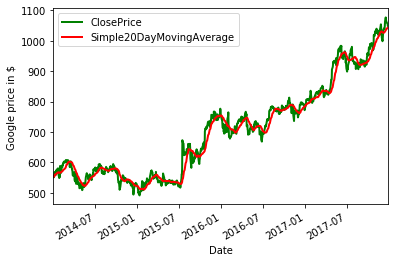

In [0]:
import statistics as stats
time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values
close = goog_data['Adj Close']
for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
    del (history[0])
  sma_values.append(stats.mean(history))

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage=pd.Series(sma_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

EMA: The EMA is similar to the simple moving average, but, instead of weighing all prices in the
history equally, it places more weight on the most recent price observation and less weight
on the older price observations.

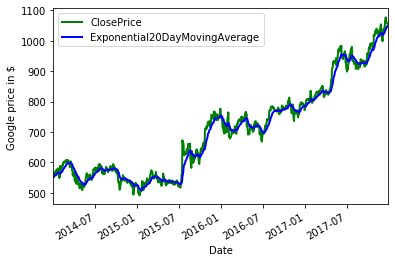

In [0]:
num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0
ema_values = [] # to hold computed EMA values
for close_price in close:
  if (ema_p == 0): # first observation, EMA = current-price
    ema_p = close_price
  else:
    ema_p = (close_price - ema_p) * K + ema_p
  ema_values.append(ema_p)

goog_data = goog_data.assign(ClosePrice=pd.Series(close,
index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema.plot(ax=ax1, color='b', lw=2., legend=True)
plt.savefig('ema.png')
plt.show()

Implementation of the absolute price oscillator

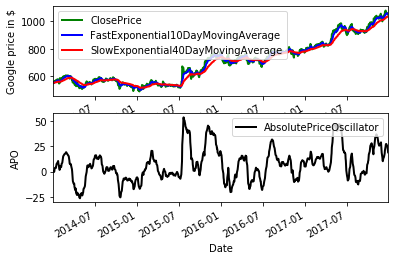

In [0]:
num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0
ema_fast_values = [] # we will hold fast EMA values for visualizationpurposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values
for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow
  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)
  apo_values.append(ema_fast - ema_slow)

goog_data = goog_data.assign(ClosePrice=pd.Series(close,index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values,
index=goog_data.index))
close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

One observation here is the difference in behavior between fast and slow EMAs. The faster
one is more reactive to new price observations, and the slower one is less reactive to new
price observations and decays slower. The APO values are positive when prices are
breaking out to the upside, and the magnitude of the APO values captures the magnitude
of the breakout. The APO values are negative when prices are breaking out to the
downside, and the magnitude of the APO values captures the magnitude of the breakout.

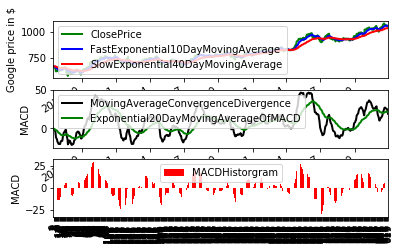

In [0]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
The Moving Average Convergence Divergence
 (MACD) was developed by Gerald Appel, and is based on the differences
 between two moving averages of different lengths, a Fast and a Slow moving
 average. A second line, called the Signal line is plotted as a moving
 average of the MACD. A third line, called the MACD Histogram is
 optionally plotted as a histogram of the difference between the
 MACD and the Signal Line.
 MACD = FastMA - SlowMA
Where:
FastMA is the shorter moving average and SlowMA is the longer moving average.
SignalLine = MovAvg (MACD)
MACD Histogram = MACD - SignalLine
 '''
num_periods_fast = 10 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0
num_periods_slow = 40 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0
num_periods_macd = 20 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
  if ema_macd == 0:
    ema_macd = macd
  else:
    ema_macd = (macd - ema_macd) * K_slow + ema_macd # signal is EMA of MACD values

  macd_values.append(macd)
  macd_signal_values.append(ema_macd)
  macd_historgram_values.append(macd - ema_macd)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.show()

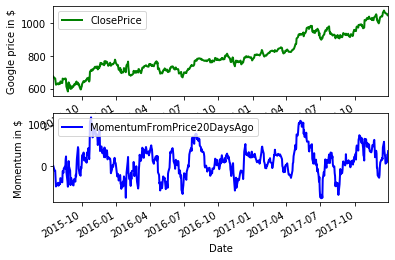

In [0]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
The Momentum (MOM) indicator compares the
 current price with the previous price from a selected number of
 periods ago. This indicator is similar to the “Rate of Change” indicator,
 but the MOM does not normalize the price, so different instruments
 can have different indicator values based on their point values.
 MOM =  Price - Price of n periods ago
 '''
time_period = 20 # how far to look back to find reference price to compute momentum
history = [] # history of observed prices to use in momentum calculation
mom_values = [] # track momentum values for visualization purposes

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # history is at most 'time_period' number of observations
    del (history[0])

  mom = close_price - history[0]
  mom_values.append(mom)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MomentumFromPrice20DaysAgo=pd.Series(mom_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
mom = goog_data['MomentumFromPrice20DaysAgo']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Momentum in $')
mom.plot(ax=ax2, color='b', lw=2., legend=True)
plt.show()

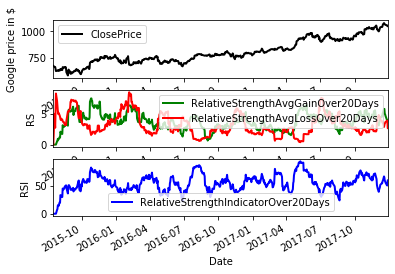

In [0]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
The Relative Strength Index (RSI) was published
 by J. Welles Wilder. The current price is normalized as a percentage
 between 0 and 100. The name of this oscillator is misleading because
 it does not compare the instrument relative to another instrument
 or set of instruments, but rather represents the current price relative
 to other recent pieces within the selected lookback window length.
 RSI = 100 - (100 / (1 + RS))
Where:
 RS = ratio of smoothed average of n-period gains divided by the
 absolute value of the smoothed average of n-period losses.
 '''
import statistics as stats

time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
  if last_price == 0:
    last_price = close_price

  gain_history.append(max(0, close_price - last_price))
  loss_history.append(max(0, last_price - close_price))
  last_price = close_price

  if len(gain_history) > time_period: # maximum observations is equal to lookback period
    del (gain_history[0])
    del (loss_history[0])

  avg_gain = stats.mean(gain_history) # average gain over lookback period
  avg_loss = stats.mean(loss_history) # average loss over lookback period

  avg_gain_values.append(avg_gain)
  avg_loss_values.append(avg_loss)

  rs = 0
  if avg_loss > 0: # to avoid division by 0, which is undefined
    rs = avg_gain / avg_loss

  rsi = 100 - (100 / (1 + rs))
  rsi_values.append(rsi)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.show()

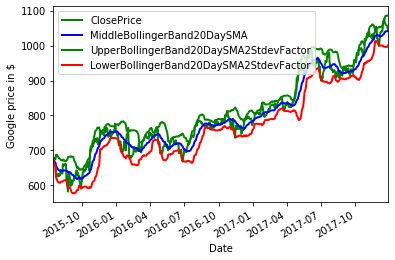

In [0]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
The Bollinger Band (BBANDS) study created
 by John Bollinger plots upper and lower envelope bands around the
 price of the instrument. The width of the bands is based on the
 standard deviation of the closing prices from a moving average of
 price.
 Middle
 Band = n-period moving average
Upper
 Band = Middle Band + ( y * n-period standard deviation)
Lower Band = Middle Band - ( y *
 n-period standard deviation)
Where:
n = number of periods
y = factor to apply to the standard deviation value, (typical default for y = 2)
Detailed:
Calculate the moving average.
 The formula is:
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n
Pn is the price you pay for the nth interval
n is the number of periods you select
Subtract the moving average
 from each of the individual data points used in the moving average
 calculation. This gives you a list of deviations from the average.
 Square each deviation and add them all together. Divide this sum
 by the number of periods you selected.
Take the square root of d. This gives you the standard deviation.
delta = sqrt(d)
Compute the bands by using the following formulas:
Upper Band = MA + delta
Middle Band = MA
Lower Band = MA - delta
 '''
import statistics as stats
import math as math

time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma) # simple moving average or middle band
  variance = 0 # variance is the square of standard deviation
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

  upper_band.append(sma + stdev_factor * stdev)
  lower_band.append(sma - stdev_factor * stdev)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()

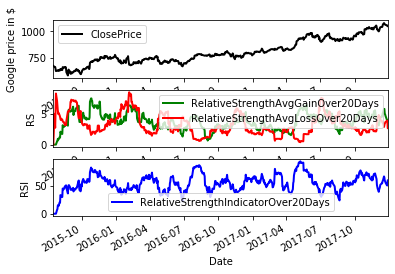

In [2]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
The Relative Strength Index (RSI) was published
 by J. Welles Wilder. The current price is normalized as a percentage
 between 0 and 100. The name of this oscillator is misleading because
 it does not compare the instrument relative to another instrument
 or set of instruments, but rather represents the current price relative
 to other recent pieces within the selected lookback window length.

 RSI = 100 - (100 / (1 + RS))

Where:
 RS = ratio of smoothed average of n-period gains divided by the
 absolute value of the smoothed average of n-period losses.
 '''
import statistics as stats

time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
  if last_price == 0:
    last_price = close_price

  gain_history.append(max(0, close_price - last_price))
  loss_history.append(max(0, last_price - close_price))
  last_price = close_price

  if len(gain_history) > time_period: # maximum observations is equal to lookback period
    del (gain_history[0])
    del (loss_history[0])

  avg_gain = stats.mean(gain_history) # average gain over lookback period
  avg_loss = stats.mean(loss_history) # average loss over lookback period

  avg_gain_values.append(avg_gain)
  avg_loss_values.append(avg_loss)

  rs = 0
  if avg_loss > 0: # to avoid division by 0, which is undefined
    rs = avg_gain / avg_loss

  rsi = 100 - (100 / (1 + rs))
  rsi_values.append(rsi)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.show()

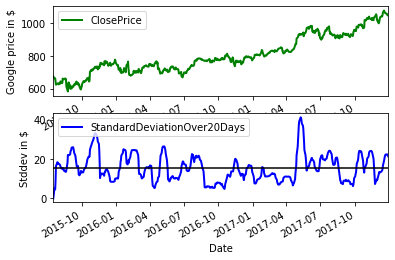

In [1]:
import pandas as pd

from pandas_datareader import data

start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
  goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
  goog_data2.to_pickle(SRC_DATA_FILENAME)

goog_data = goog_data2.tail(620)

close = goog_data['Close']

'''
Standard Deviation is a statistical calculation
 used to measure the variability. In trading this value is known
 as volatility. A low standard deviation indicates that the data
 points tend to be very close to the mean, whereas high standard
 deviation indicates that the data points are spread out over a large
 range of values.

n = number of periods

Calculate the moving average.
 The formula is:
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval
n is the number of periods you select

Take the square root of d. This gives you the standard deviation.

stddev = sqrt(d)

 '''
import statistics as stats
import math as math

time_period = 20 # look back period
history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we track at most 'time_period' number of prices
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma)
  variance = 0 # variance is square of standard deviation
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(history))

  stddev_values.append(stdev)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(StandardDeviationOver20Days=pd.Series(stddev_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
stddev = goog_data['StandardDeviationOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
stddev.plot(ax=ax2, color='b', lw=2., legend=True)
ax2.axhline(y=stats.mean(stddev_values), color='k')
plt.show()

File not found...downloading the GOOG data


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5092867756315007 0.5296735905044511


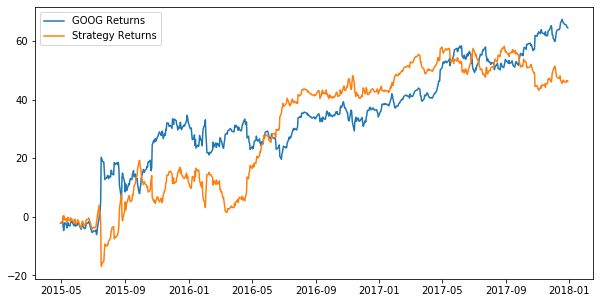

0.5092867756315007 0.5296735905044511
0.18666466338541046


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


from pandas_datareader import data
start_date = '2001-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data_large.pkl'

try:
    goog_data = pd.read_pickle(SRC_DATA_FILENAME)
    print('File data found...reading GOOG data')
except FileNotFoundError:
    print('File not found...downloading the GOOG data')
    goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data.to_pickle(SRC_DATA_FILENAME)

goog_data['Open-Close']=goog_data.Open-goog_data.Close
goog_data['High-Low']=goog_data.High-goog_data.Low
goog_data=goog_data.dropna()
X=goog_data[['Open-Close','High-Low']]
Y=np.where(goog_data['Close'].shift(-1)>goog_data['Close'],1,-1)

split_ratio=0.8
split_value=int(split_ratio * len(goog_data))
X_train=X[:split_value]
Y_train=Y[:split_value]
X_test=X[split_value:]
Y_test=Y[split_value:]


logistic=LogisticRegression()
logistic.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)


goog_data['Predicted_Signal']=logistic.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))





#                                  goog_data['Close'].shift(1))
# cum_goog_return=goog_data[split_value:]['GOOG_Returns'].cumsum()*100
#
# goog_data['Strategy_Returns']=goog_data['GOOG_Returns'] * goog_data['Predicted_Signal'].shift(1)
# cum_strategy_return=goog_data[split_value:]['Strategy_Returns'].cumsum()*100
#
# plt.figure(figsize=(10,5))
# plt.plot(cum_goog_return,label='GOOG Returns')
# plt.plot(cum_strategy_return,label='Strategy Returns')
# plt.legend()
# plt.show()
#
#
# def sharpe_ratio(symbol_returns, strategy_returns):
#     strategy_std=strategy_returns.std()
#     sharpe=(strategy_returns-symbol_returns)/strategy_std
#     return sharpe.mean()
#
# print(sharpe_ratio(cum_strategy_return,cum_goog_return))